# 第5章 時系列予測事例

## 5.2 数理最適化問題・速習超入門

### 5.2.3 数理最適化ライブラリとその使い方

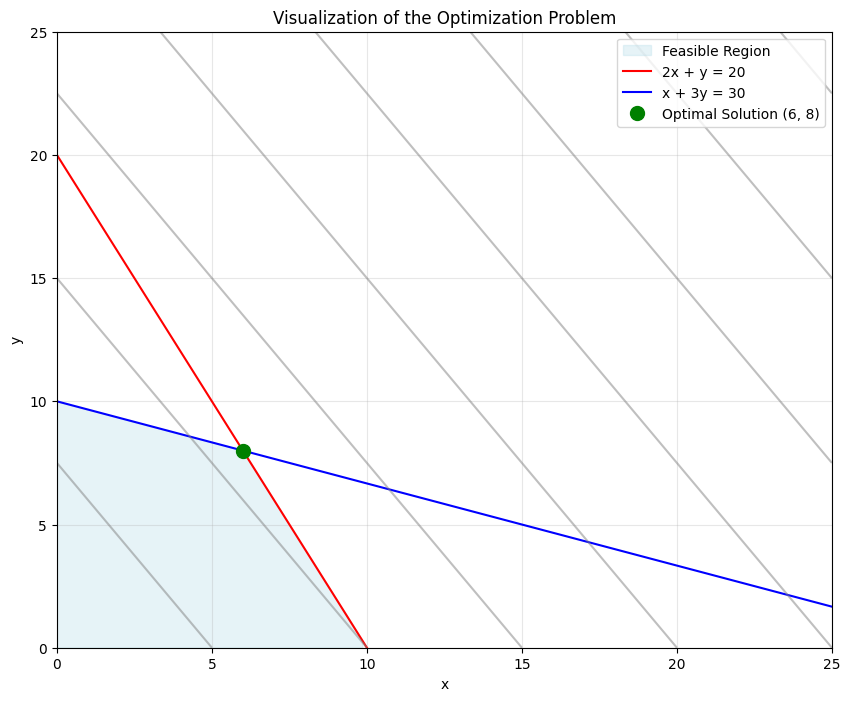

In [1]:
#
# code 5.1
#

import matplotlib.pyplot as plt
import numpy as np

# データポイントの生成
x = np.linspace(0, 25, 100)

# 制約条件の線を計算
y1 = (20 - 2*x) # 2x + y <= 20
y2 = (30 - x)/3 # x + 3y <= 30

# プロットの描画
plt.figure(figsize=(10, 8))

# 実行可能領域をプロット
plt.fill_between(
    x,
    np.minimum(y1, y2),
    0,
    where=(x >= 0) & (np.minimum(y1, y2) >= 0),
    alpha=0.3,
    color='lightblue',
    label='Feasible Region'
)

# 制約条件の線をプロット
plt.plot(x, y1, 'r-', label='2x + y = 20')
plt.plot(x, y2, 'b-', label='x + 3y = 30')

# 最適解をプロット
plt.plot(
    6, 8,
    'go', markersize=10,
    label='Optimal Solution (6, 8)'
)

# 目的関数の等高線
x_mesh, y_mesh = np.meshgrid(
    np.linspace(0, 25, 100),
    np.linspace(0, 25, 100)
)
z = 3*x_mesh + 2*y_mesh
plt.contour(
    x_mesh, y_mesh, z,
    levels=10, alpha=0.5, colors='gray'
)

# グラフの設定
plt.grid(True, alpha=0.3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Visualization of the Optimization Problem')
plt.legend()
plt.xlim(0, 25)
plt.ylim(0, 25)
plt.show()

In [2]:
#
# code 5.2
#

import pulp

# 問題の定義（最大化問題の場合、pulp.LpMaximize を指定）
problem = pulp.LpProblem("Simple_Problem", pulp.LpMaximize)

# 変数の定義（ここでは x と y を非負の連続変数として定義）
x = pulp.LpVariable('x', lowBound=0)
y = pulp.LpVariable('y', lowBound=0)

# 目的関数の定義：maximize 3x + 2y
problem += 3 * x + 2 * y, "Objective_Function"

# 制約条件の追加
problem += 2 * x + y <= 20, "Constraint_1"
problem += x + 3 * y <= 30, "Constraint_2"

# 最適化問題の解決
problem.solve()

# 結果の出力
print("Status:", pulp.LpStatus[problem.status])
print("Optimal solution:")
print("x =", x.varValue)
print("y =", y.varValue)
print("Objective value =", pulp.value(problem.objective))


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

Status: Optimal
Optimal solution:
x = 6.0
y = 8.0
Objective value = 34.0


In [3]:
#
# code 5.3
#

solver = pulp.PULP_CBC_CMD(
    msg=False,     # ログ非表示
    timeLimit=600, # 制限時間（秒）
    threads=4,     # スレッド数
)

## 5.3 Python 実装事例（需要予測と在庫最適化）

In [4]:
#
# code 5.4
#

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import Dict
from tqdm import tqdm
from prophet import Prophet
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)

# Warning/Logging の設定
import warnings
import logging
warnings.simplefilter('ignore')
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

# CSV ファイルの読み込み
sales_data = pd.read_csv('sales_data.csv')

print(sales_data)

        store_id  product_id        date  sales  is_special_day
0              1           1  2022-04-01    108               0
1              1           1  2022-04-02    121               1
2              1           1  2022-04-03    108               0
3              1           1  2022-04-04    114               0
4              1           1  2022-04-05    125               0
...          ...         ...         ...    ...             ...
164395        15          10  2025-03-27    306               0
164396        15          10  2025-03-28    297               0
164397        15          10  2025-03-29    286               0
164398        15          10  2025-03-30    293               0
164399        15          10  2025-03-31    302               0

[164400 rows x 5 columns]


In [5]:
#
# code 5.5
#

# 指定した店舗の商品カテゴリの時系列推移をプロットする関数
def plot_products_for_store(store_id):

    # 指定された店舗のデータを抽出
    store_data = sales_data[sales_data['store_id'] == store_id]

    # その店舗で扱っている商品カテゴリの一覧を取得
    unique_products = store_data['product_id'].unique()

    # 2行5列のサブプロットを設定
    num_products = len(unique_products)
    fig, axs = plt.subplots(2, 5, figsize=(10, 3))

    # 2次元配列のaxesを1次元化
    axs = axs.flatten()

    # 各商品ごとにプロットを作成
    for i, product_id in enumerate(unique_products):
        if i >= len(axs):
            break  # プロット数が軸の数を超えた場合は処理を中断

        # 特定の商品カテゴリのデータを抽出してプロット
        product_data = store_data[
            store_data['product_id'] == product_id]
        axs[i].plot(
            product_data['date'], 
            product_data['sales'], 
            label=f'Product {product_id}', 
            linewidth=0.8
        ) 

        # プロットの設定
        axs[i].set_title(f'Product {product_id}')
        axs[i].grid()
        axs[i].xaxis.set_visible(False)

    # グラフ全体のタイトルを設定
    fig.suptitle(
        f'Sales plots for Each Product in Store {store_id}', 
        fontsize=16
    )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

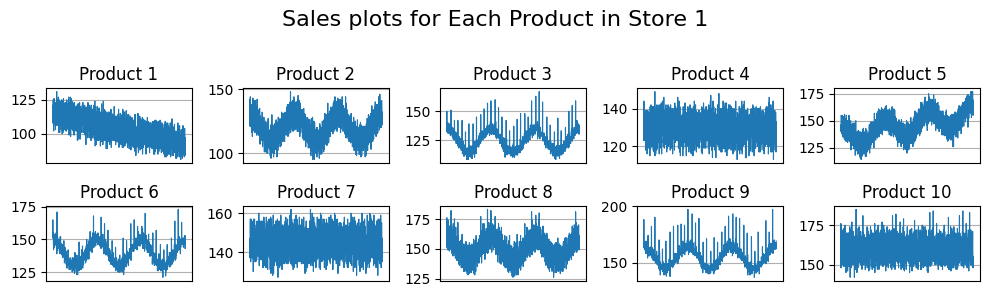

In [6]:
#
# code 5.6
#

# 店舗ID=1のデータをプロット
plot_products_for_store(1)

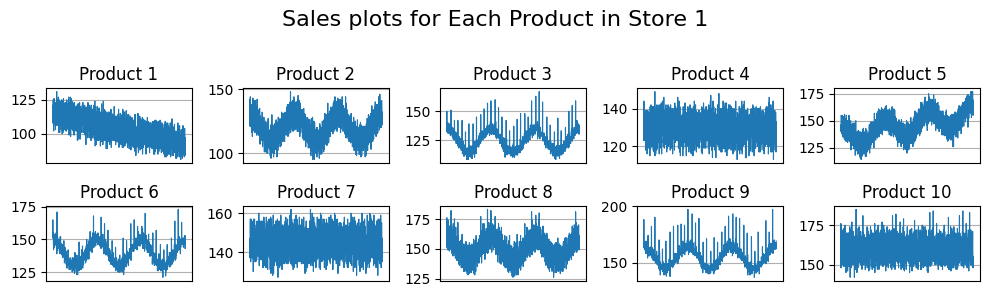

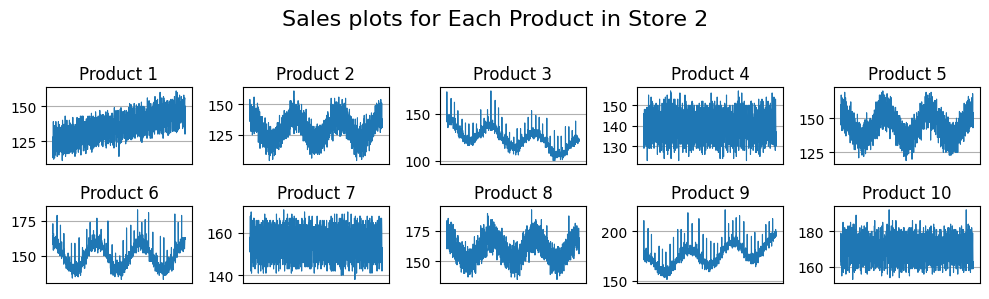

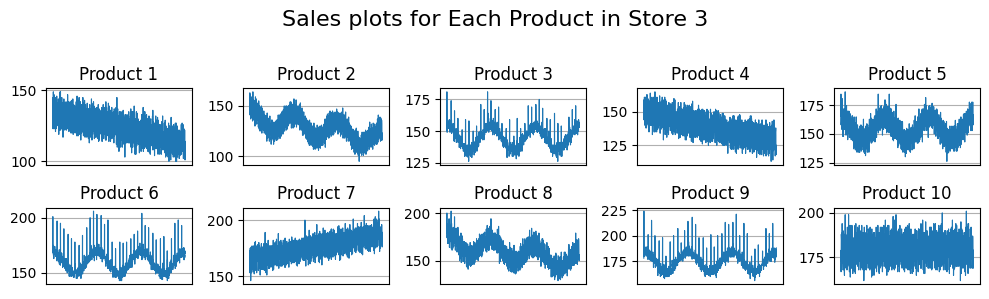

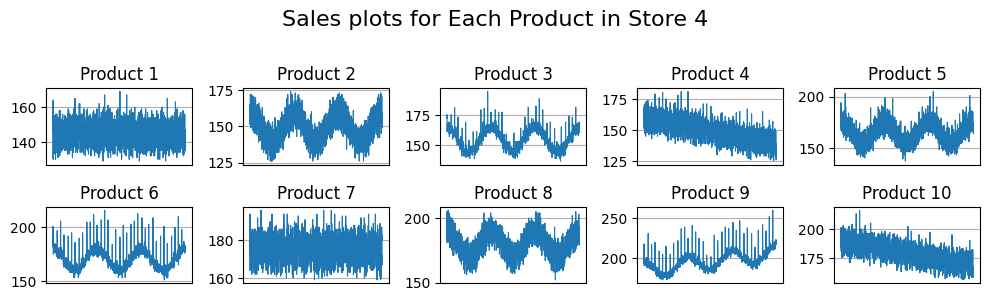

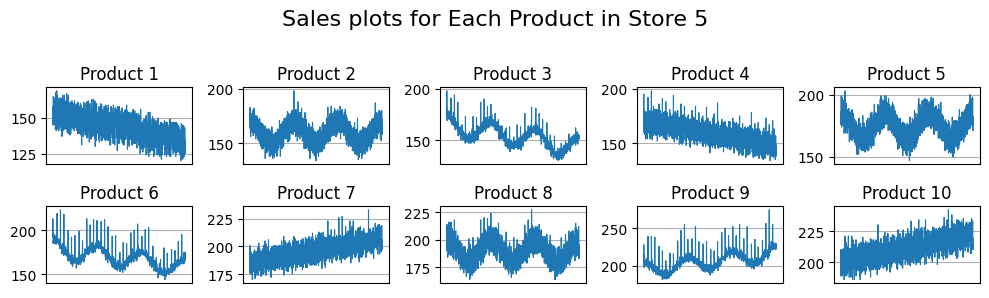

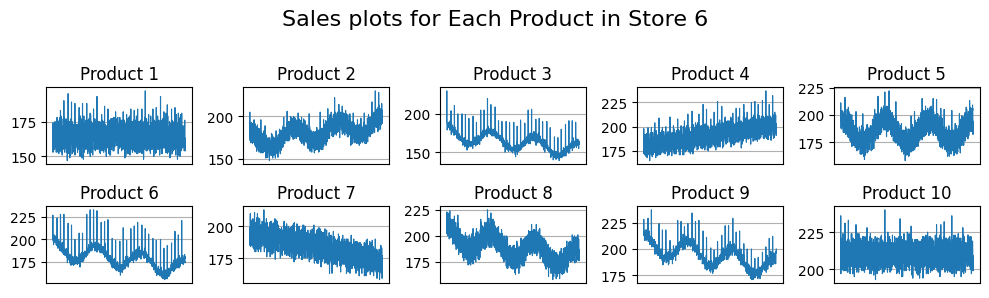

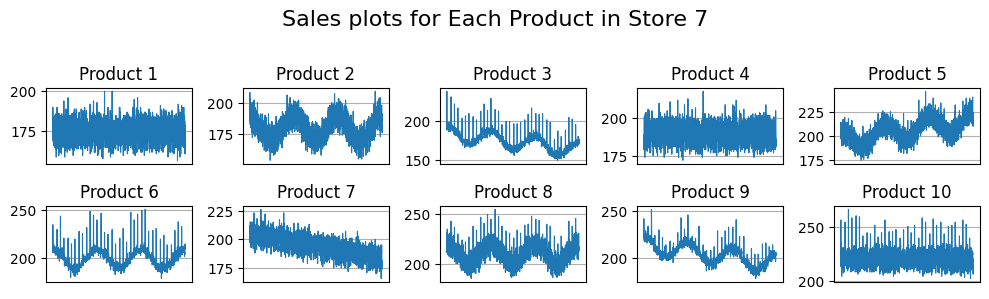

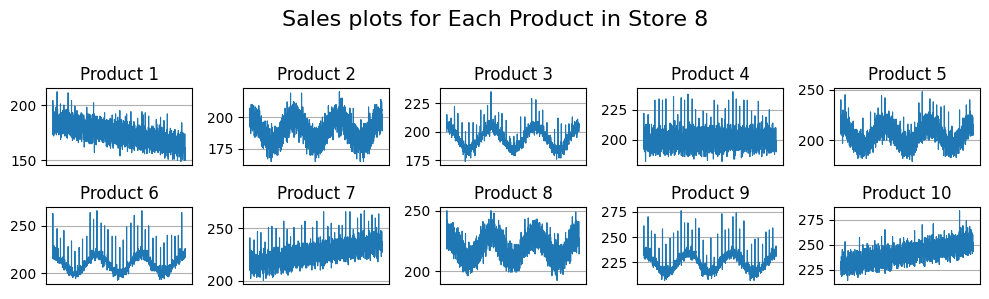

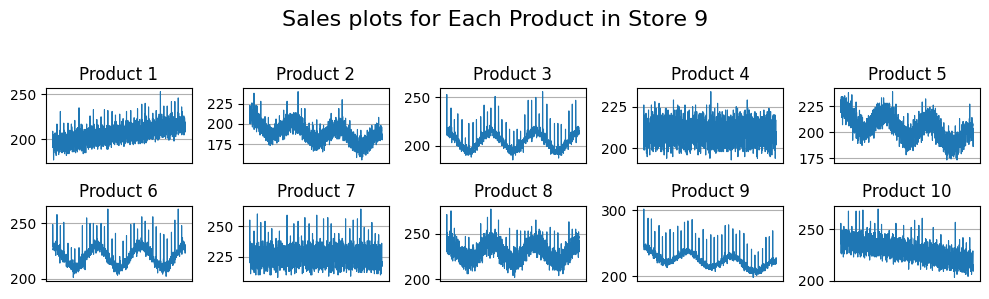

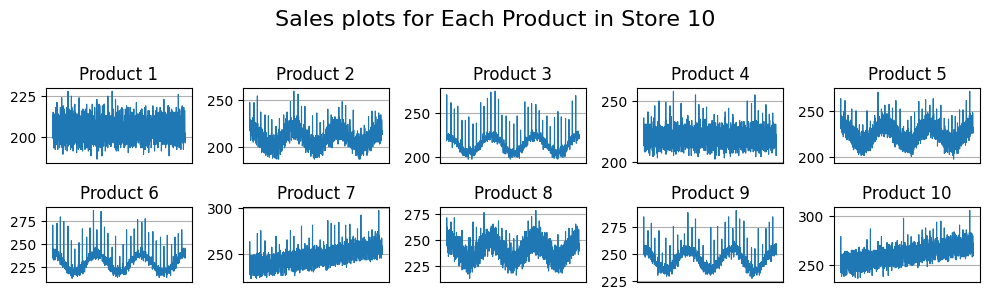

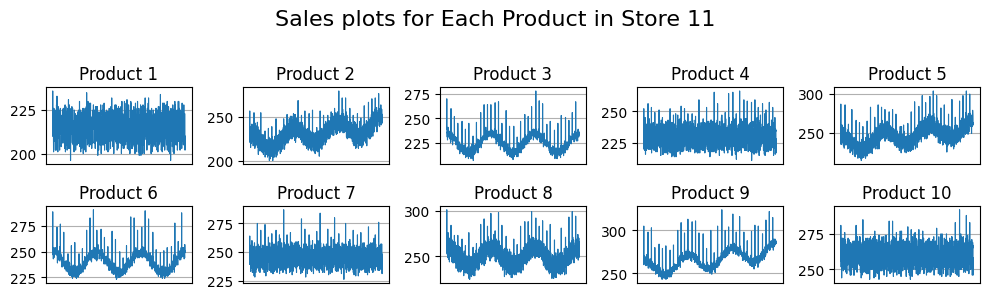

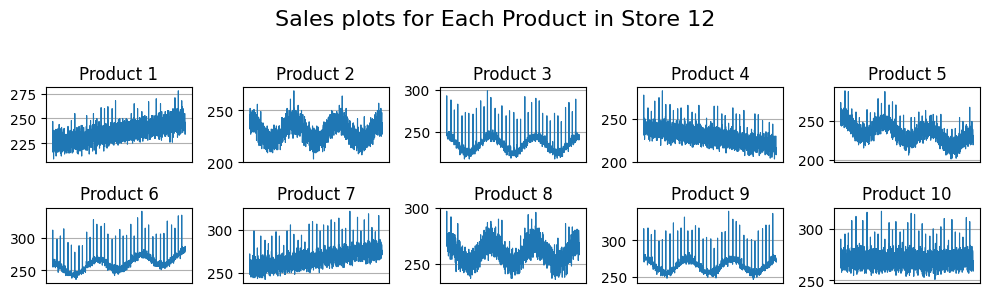

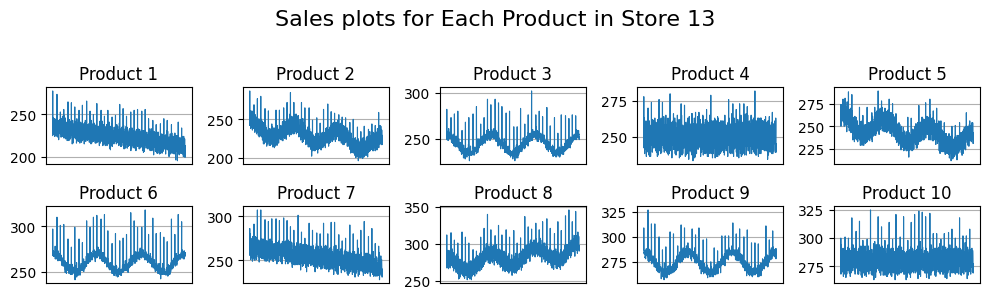

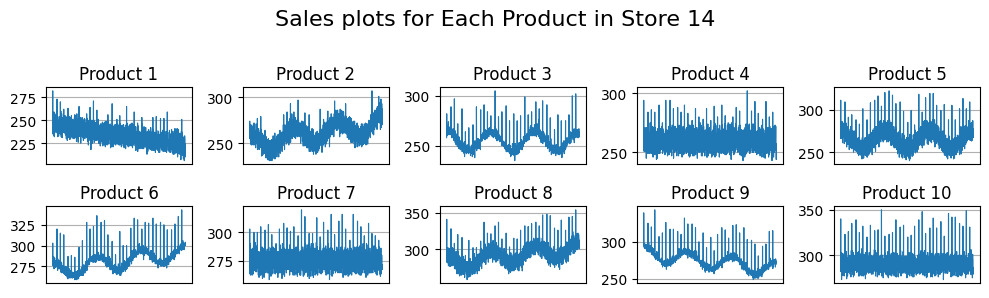

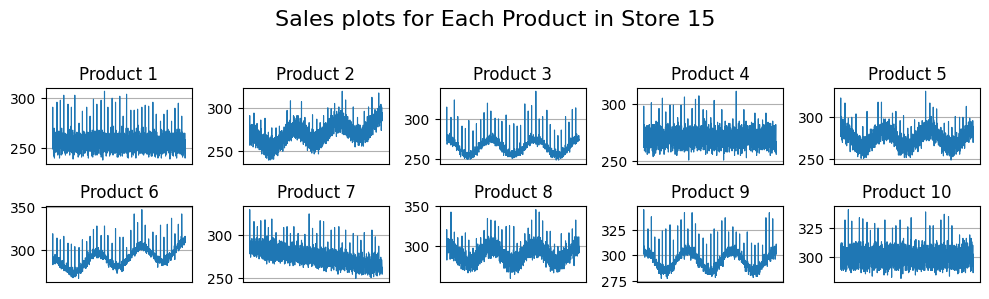

In [7]:
# 全店舗のデータをプロット
store_ids = sales_data['store_id'].unique()
for store_id in store_ids:
    plot_products_for_store(store_id)

In [8]:
#
# code 5.7
#

# Prophet用のデータを準備する関数
def prepare_prophet_data(
    data,        # データセット
    store_id,    # 店舗ID
    product_id,  # 商品ID
):
    # 指定された店舗と商品のデータを抽出
    filtered_data = data[
        (data['store_id'] == store_id) & 
        (data['product_id'] == product_id)
    ].sort_values(by='date')
    # Prophet用のデータを作成し返す
    return pd.DataFrame({
        'ds': pd.to_datetime(filtered_data['date']),
        'y': filtered_data['sales'],
        'is_special_day': filtered_data['is_special_day'],
    })

# Prophetモデルを作成する関数
def create_prophet_model():
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        seasonality_mode='multiplicative'
    )
    model.add_regressor('is_special_day')
    # モデルを返す
    return model

# 評価指標を計算する関数
def calculate_metrics(
    actual, # 実測値
    pred,   # 予測値
):
    # 評価指標を計算し返す
    return {
        'rmse': np.sqrt(mean_squared_error(actual, pred)),
        'mae': mean_absolute_error(actual, pred),
        'mape': mean_absolute_percentage_error(actual, pred)
    }

# 評価指標の表示フォーマットを整える関数
def format_metrics(
    metrics, # calculate_metrics()の戻り値
):
    return {
        'rmse': f"{metrics['rmse']:.2f}",
        'mae': f"{metrics['mae']:.2f}", 
        'mape': f"{metrics['mape']*100:.2f}%"
    }

In [9]:
#
# code 5.8
#

# 指定した店舗・商品に対してモデルを学習し評価する関数
def train_test_model(
    data,       # データセット
    store_id,   # 店舗ID
    product_id, # 商品ID
    test_size,
):
    # データ準備
    prophet_df = prepare_prophet_data(data, store_id, product_id)

    # 学習・テストデータ分割
    train_size = len(prophet_df) - test_size
    train_data = prophet_df[:train_size]
    test_data = prophet_df[train_size:]

    # モデル学習
    model = create_prophet_model()
    model.fit(train_data)

    # 予測実行
    future = pd.DataFrame({
        'ds': test_data['ds'],
        'is_special_day': test_data['is_special_day'],
    })
    forecast = model.predict(future)

    # 評価指標計算
    metrics = calculate_metrics(
        test_data['y'].values,
        forecast['yhat'].values
    )

    # 学習済みモデルと予測結果を返す
    return metrics, model, forecast

In [10]:
#
# code 5.9
#

# 全店舗・商品のモデルを学習し評価する関数
def train_all_models(
    data, 
    test_size,
):
    # 店舗リストと商品リストを作成
    store_ids = data['store_id'].unique()
    product_ids = data['product_id'].unique()

    # 結果を格納するリスト
    results = []

    # モデル学習と評価を繰り返す
    total_tasks = len(store_ids) * len(product_ids)
    with tqdm(total=total_tasks) as pbar:
        for store_id in store_ids:
            for product_id in product_ids:

                # モデル学習と評価
                metrics, _, _ = train_test_model(
                    data,
                    store_id,
                    product_id,
                    test_size
                )

                # 結果をリストに格納
                result = {
                    'store_id': store_id,
                    'product_id': product_id,
                    **metrics
                }
                results.append(result)
                
                # プログレスバーを更新
                pbar.set_postfix({
                    'store_id': store_id,
                    'product_id': product_id,
                    **format_metrics(metrics)
                })
                pbar.update(1)

    # 結果をデータフレームに変換し返す
    return pd.DataFrame(results)

In [11]:
#
# code 5.10
#

results_df = train_all_models(sales_data,test_size=365)

100%|██████████| 150/150 [01:25<00:00,  1.74it/s, store_id=15, product_id=10, rmse=3.42, mae=2.61, mape=0.87%]


In [12]:
#
# code 5.11
#

print(results_df[['rmse','mae','mape']].describe())

             rmse         mae        mape
count  150.000000  150.000000  150.000000
mean     3.448470    2.707583    0.013812
std      0.290381    0.244279    0.003517
min      2.949559    2.361741    0.008662
25%      3.291174    2.559503    0.011073
50%      3.393710    2.662902    0.013105
75%      3.545952    2.751910    0.016402
max      5.417499    4.529262    0.024894


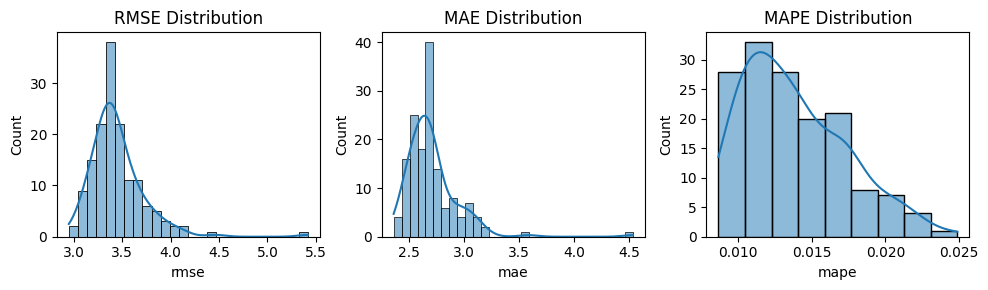

In [13]:
#
# code 5.12
#

# サブプロットを1行3列で作成
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

# RMSEの分布をヒストグラムで表示
sns.histplot(data=results_df['rmse'], ax=ax1, kde=True)
ax1.set_title('RMSE Distribution')

# MAEの分布をヒストグラムで表示
sns.histplot(data=results_df['mae'], ax=ax2, kde=True)
ax2.set_title('MAE Distribution')

# MAPEの分布をヒストグラムで表示
sns.histplot(data=results_df['mape'], ax=ax3, kde=True)
ax3.set_title('MAPE Distribution')

plt.tight_layout()
plt.show()

In [14]:
#
# code 5.13
#

# 予測対象期間の日付を生成する関数
def generate_future_dates(
    data,          # データセット（過去）
    forecast_days, # 予測日数（未来）
):
    # データセット（過去）の最後の日付を取得
    latest_date = pd.to_datetime(data['date']).max()

    # 予測対象期間の日付を生成し返す
    return pd.date_range(
        start=latest_date + timedelta(days=1),
        periods=forecast_days,
        freq='D'
    )

# 予測対象期間のXを準備する関数
def prepare_future_dataframe(
    future_dates,  # 予測対象期間の日付
):
    # 予測対象期間のXを作成し返す
    return pd.DataFrame({
        'ds': future_dates,
        'is_special_day': [
            (d.weekday() == 5 and d.day <= 7) 
            for d in future_dates
        ]
    })

# Prophetモデルを作成する関数
def create_prophet_model():
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        seasonality_mode='multiplicative'
    )
    model.add_regressor('is_special_day')
    # モデルを返す
    return model

# Prophet用のデータフレームを作成する関数
def prepare_prophet_data(
    data,          # データセット（過去）
    store_id,      # 店舗ID
    product_id,    # 商品ID
):
    # 指定された店舗と商品のデータを抽出
    filtered_data = data[
        (data['store_id'] == store_id) & 
        (data['product_id'] == product_id)
    ].sort_values(by='date')

    # 日付をdatetime型に変換
    dates = pd.to_datetime(filtered_data['date'])
    
    # Prophet用のデータフレームを作成し返す
    return pd.DataFrame({
        'ds': dates,
        'y': filtered_data['sales'],
        'is_special_day': filtered_data['is_special_day']
    })

In [15]:
#
# code 5.14
#

# 指定した店舗・商品カテゴリの予測を実施する関数
def generate_single_prediction(
    store_id,     # 店舗ID
    product_id,   # 商品ID
    model,        # Prophetモデル
    future_dates, # 予測対象期間
    future_df,    # 予測対象期間のX
):
    # 予測
    forecast = model.predict(future_df)

    # 予測結果（予測値と予測区間）を格納
    predictions = []
    for date, pred, lower, upper in zip(
        future_dates,
        forecast['yhat'].values,
        forecast['yhat_lower'].values,
        forecast['yhat_upper'].values
    ):
        predictions.append({
            'store_id': store_id,
            'product_id': product_id,
            'date': date,
            'forecast': int(round(pred)),
            'lower_bound': int(round(lower)),
            'upper_bound': int(round(upper))
        })
        
    # 予測結果を返す
    return predictions

In [16]:
#
# code 5.15
#

# 全ての店舗・商品カテゴリの組み合わせに対する予測を実施する関数
def generate_forecasts(
    data,          # データセット（過去）
    forecast_days, # 予測日数（未来）
):
    # 店舗リストと商品リストを作成
    store_ids = data['store_id'].unique()
    product_ids = data['product_id'].unique()

    # 予測結果を格納するリスト
    all_predictions = []

    # 予測日付の生成
    future_dates = generate_future_dates(data, forecast_days)
    future_df = prepare_future_dataframe(future_dates)

    # 学習と予測を繰り返す
    for store_id in store_ids:
        for product_id in product_ids:

            # データの準備とモデルの学習
            prophet_data = prepare_prophet_data(
                data, 
                store_id, 
                product_id
            )
            model = create_prophet_model()
            model.fit(prophet_data)

            # 予測の実行
            predictions = generate_single_prediction(
                store_id,
                product_id,
                model,
                future_dates,
                future_df
            )

            # 予測結果をリストに格納
            all_predictions.extend(predictions)

    # 予測結果をデータフレームに変換し返す
    return pd.DataFrame(all_predictions)

In [17]:
#
# code 5.16
#

future_forecast = generate_forecasts(sales_data, 56)

In [18]:
#
# code 5.17
#

# 結果をCSVファイルに保存
future_forecast.to_csv('future_forecast.csv', index=False)

### 5.3.3 需要予測結果を使った在庫最適化

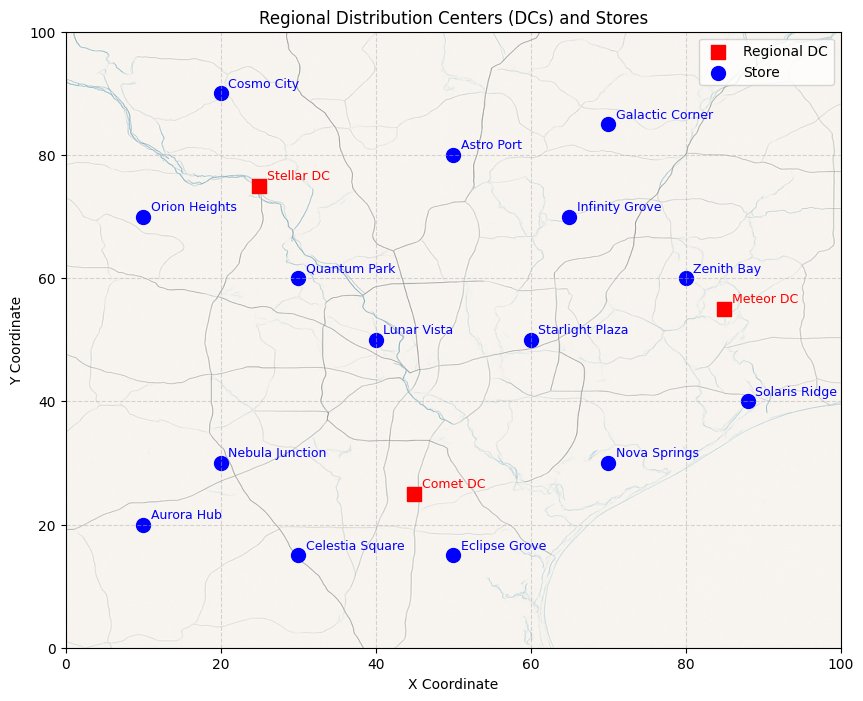

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 図の設定
plt.figure(figsize=(10, 8))
img = mpimg.imread("map_background.png")
plt.imshow(img, extent=[0, 100, 0, 100], aspect='auto')

# 配送センター（Regional DCs）の座標と名称
warehouse_coords = {
    "Stellar DC": (25, 75),
    "Meteor DC": (85, 55),
    "Comet DC": (45, 25)
}

# 店舗（Stores）の座標と名称（全15店舗）
store_coords = {
    "Aurora Hub": (10, 20),
    "Nebula Junction": (20, 30),
    "Celestia Square": (30, 15),
    "Lunar Vista": (40, 50),
    "Eclipse Grove": (50, 15),
    "Starlight Plaza": (60, 50),
    "Nova Springs": (70, 30),
    "Zenith Bay": (80, 60),
    "Cosmo City": (20, 90),
    "Orion Heights": (10, 70),
    "Quantum Park": (30, 60),
    "Astro Port": (50, 80),
    "Galactic Corner": (70, 85),
    "Infinity Grove": (65, 70),
    "Solaris Ridge": (88, 40)
}

# 配送センターを赤い四角形でプロット
for name, (x, y) in warehouse_coords.items():
    plt.scatter(x, y, color='red', marker='s', s=100, 
                label='Regional DC' if name == list(warehouse_coords.keys())[0] else "")
    plt.text(x + 1, y + 1, name, fontsize=9, color='red')

# 店舗を青い丸でプロット
for name, (x, y) in store_coords.items():
    plt.scatter(x, y, color='blue', marker='o', s=100, 
                label='Store' if name == list(store_coords.keys())[0] else "")
    plt.text(x + 1, y + 1, name, fontsize=9, color='blue')

plt.title("Regional Distribution Centers (DCs) and Stores")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [20]:
#
# code 5.18
#

import numpy as np
import pandas as pd
import pulp
import time
from datetime import datetime, timezone, timedelta

# データ読み込み
stores = pd.read_csv('stores.csv').set_index('store_id')
products = pd.read_csv('products.csv').set_index('product_id')
warehouses = pd.read_csv('warehouses.csv').set_index('warehouse_id')
demand_forecast = pd.read_csv('future_forecast.csv')
inventory_costs = pd.read_csv('inventory_costs.csv').set_index('product_id')
transportation_costs = pd.read_csv('transportation_costs.csv')

# 日付型に変換
demand_forecast['date'] = pd.to_datetime(demand_forecast['date'])

print("\n-- 店舗の容量 --\n",stores.head())
print("\n-- 商品アイテム --\n",products.head())
print("\n-- 地域配送センターの倉庫 --\n",warehouses.head())
print("\n-- 需要予測結果 --\n",demand_forecast.head())
print("\n-- 単位在庫・欠品ペナルティコスト --\n",inventory_costs.head())
print("\n-- 輸送コスト・リードタイム --\n",transportation_costs.head())


-- 店舗の容量 --
                      name  max_capacity
store_id                               
1              Aurora Hub         15000
2         Nebula Junction         12000
3         Celestia Square         13000
4             Lunar Vista         11000
5           Eclipse Grove         14000

-- 商品アイテム --
                      name  category  volume
product_id                                 
1                    Milk      Food       1
2                   Bread      Food       1
3                    Eggs      Food       1
4                 Chicken      Food       2
5           Bottled Water  Beverage       3

-- 地域配送センターの倉庫 --
                     name  capacity
warehouse_id                      
1             Stellar DC    500000
2              Meteor DC    400000
3               Comet DC    450000

-- 需要予測結果 --
    store_id  product_id       date  forecast  lower_bound  upper_bound
0         1           1 2025-04-01       100           96          103
1         1           1 2025-04

In [21]:
#
# code 5.19
#

# 店舗・商品カテゴリ・地域配送センター・日付のリスト作成
stores_list = stores.index.tolist()
products_list = products.index.tolist()
warehouses_list = warehouses.index.tolist()
dates = sorted(demand_forecast['date'].unique())

# 輸送コストの辞書作成
transport_cost_dict = {
    (row['warehouse_id'], row['store_id']): row['cost_per_unit'] 
    for _, row in transportation_costs.iterrows()
}

# リードタイムの辞書作成
lead_time_dict = {
    (row['warehouse_id'], row['store_id']): row['lead_time'] 
    for _, row in transportation_costs.iterrows()
}

# 需要の辞書作成
demand_dict = {
    (row['store_id'], row['product_id'], row['date']): row['forecast'] 
    for _, row in demand_forecast.iterrows()
}

In [22]:
#
# code 5.20
#

# 最適化問題の定義
prob = pulp.LpProblem("Inventory_Optimization", pulp.LpMinimize)

# 決定変数
x = pulp.LpVariable.dicts(
    "ship", 
    ((w, s, p, d) for w in warehouses_list 
    for s in stores_list 
    for p in products_list 
    for d in dates), 
    lowBound=0, cat='Integer'
)
I = pulp.LpVariable.dicts(
    "inventory", 
    ((s, p, d) for s in stores_list 
    for p in products_list 
    for d in dates), 
    lowBound=0, cat='Integer'
)
U = pulp.LpVariable.dicts(
    "stockout", 
    ((s, p, d) for s in stores_list 
    for p in products_list 
    for d in dates), 
    lowBound=0, cat='Integer'
)

# 目的関数
prob += (
    pulp.lpSum(
        inventory_costs.loc[p, 'holding_cost'] * I[s, p, d] +
        inventory_costs.loc[p, 'stockout_cost'] * U[s, p, d]
        for s in stores_list 
        for p in products_list 
        for d in dates) +
    pulp.lpSum(
        transport_cost_dict[w, s] * x[w, s, p, d]
        for w in warehouses_list 
        for s in stores_list 
        for p in products_list 
        for d in dates
    )
)

# 在庫バランス制約のヘルパー関数
def get_shipping_date(d, lead_time):
    return max(dates[0], d - timedelta(days=lead_time))
    
# 在庫バランス制約
for s in stores_list:
    for p in products_list:
        for t, d in enumerate(dates):
            if t == 0:
                prob += I[s, p, d] == sum(
                    x[w, s, p, get_shipping_date(
                        d, 
                        lead_time_dict[w, s]
                    )] 
                    for w in warehouses_list) - \
                    demand_dict.get((s, p, d), 0) + U[s, p, d]
            else:
                prob += I[s, p, d] == I[s, p, dates[t-1]] + \
                    sum(x[w, s, p, get_shipping_date(d, lead_time_dict[w, s])] 
                        for w in warehouses_list) - \
                        demand_dict.get((s, p, d), 0) + U[s, p, d]

# 倉庫在庫制約
for w in warehouses_list:
    for d in dates:
        prob += pulp.lpSum(
            products.loc[p, 'volume'] * x[w, s, p, d] 
            for s in stores_list 
            for p in products_list) <= warehouses.loc[w, 'capacity']

# 店舗容量制約
for s in stores_list:
    for d in dates:
        prob += pulp.lpSum(
            products.loc[p, 'volume'] * I[s, p, d] 
            for p in products_list) <= stores.loc[s, 'max_capacity']

In [23]:
#
# code 5.21
#

# 最適化ソルバーの設定
solver = pulp.PULP_CBC_CMD(
    msg=False,     # ログ非表示
    timeLimit=600, # 制限時間（秒）
    threads=4,     # スレッド数
)

# 最適化を実行
result = prob.solve(solver)

# 最適化の概要
print(f"Status: {pulp.LpStatus[prob.status]}")
print(f"Total Cost: ${pulp.value(prob.objective):,.2f}")

Status: Optimal
Total Cost: $5,034,408.61


In [24]:
#
# code 5.22
#

# 発注レコメンドリストの作成
order_plan = []
for d in dates:
    for s in stores_list:
        for w in warehouses_list:
            for p in products_list:
                quantity = x[w, s, p, d].varValue
                if quantity > 0:
                    order_plan.append({
                        'date': d,
                        'store_id': s,
                        'warehouse_id': w,
                        'product_id': p,
                        'quantity': quantity
                    })
                    
# 発注レコメンドリストのデータフレーム化
order_plan_df = pd.DataFrame(order_plan)

print(order_plan_df)

           date  store_id  warehouse_id  product_id  quantity
0    2025-04-01         1             1           1     167.0
1    2025-04-01         1             1           2     303.0
2    2025-04-01         1             1           3     238.0
3    2025-04-01         1             1           4     196.0
4    2025-04-01         1             1           5     423.0
...         ...       ...           ...         ...       ...
7695 2025-05-25        10             1           6     234.0
7696 2025-05-25        10             1           7     258.0
7697 2025-05-25        10             1           8     245.0
7698 2025-05-25        10             1           9     251.0
7699 2025-05-25        10             1          10     273.0

[7700 rows x 5 columns]


In [25]:
# 結果をCSVファイルに保存
order_plan_df.to_csv('order_plan.csv', index=False)